# Домашнее задание по теме: Кластеризация

## Подготовка окружения

In [1]:
# ВНИМАНИЕ: необходимо удостовериться, что виртуальная среда выбрана правильно!

# Для MacOS/Ubuntu
# !which pip

# Для Windows
# !where pip

In [2]:
# !conda install matplotlib numpy scikit-learn seaborn -y

In [3]:
# !conda install basemap matplotlib -y

In [4]:
# !conda install -c conda-forge umap-learn -y

In [12]:
# ipympl + widget включает интерактивные функции matplotlib
 
# !conda install ipympl -y
# !conda install -c conda-forge nodejs -y
# !conda install -c conda-forge/label/gcc7 nodejs -y
# !conda install -c conda-forge/label/cf201901 nodejs -y
# !conda install -c conda-forge/label/cf202003 nodejs -y

**ВНИМАНИЕ:**

При установке `labextension` может возникнуть Warning:
```
Config option `kernel_spec_manager_class` not recognized by `InstallLabExtensionApp`.
[W 2021-07-03 10:54:07.747 LabApp] Config option `kernel_spec_manager_class` not recognized by `LabApp`.
```
Это предупреждение не должно повлиять на результат.

После это очень важно перезапустить `jupyter-lab`. Для выключения недостаточно закрыть окно, нужно воспользоваться командой `File -> Shut Down`. Затем можно привычным способом запусить `jupyter-lab`.

In [13]:
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# !jupyter labextension install jupyter-matplotlib
# !jupyter nbextension enable --py widgetsnbextension

## **ВНИМАНИЕ**

- **Задания описаны кратко, только самое необходимое, в основном только идеи и подсказки. Это творческая работа.**

- Для выполнения заданий можно использовать любые удобные способы, если в комментариях к заданию не указан конкретный метод.

- Желательно использовать максимум пройденной информации или более продвинутые способы (если нашли самостоятельно).

- Желательно писать свои идеи/мысли по поводу методов/результатов.

- В строке "Подсказка" могут быть перечислены какие-то методы, которыми можно воспользоваться, но это не обязательно, так как это только один из множества вариантов (не факт, что лучший).

- Графики можно рисовать любым способом / цветом и т.п. Главное, чтобы было понятно, что там изображено.

- При выполнении задания необходимо понимать, что значит каждое слово (на английском). Если значение слова непонятно, то необходимо разобраться с его значением самостоятельно. Пожалуйста, будьте внимательны, перепроверяйте значения слов, если не уверены.

## Импорт необходимых пакетов

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import numpy as np
import pandas as pd

from umap import UMAP
from sklearn.decomposition import PCA

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

### Загрузка данных

[Источник (Medical Cost Personal Datasets)](https://www.kaggle.com/mirichoi0218/insurance)

In [7]:
df = pd.read_csv("./../../data/insurance.csv", index_col=0)
df

,sex,bmi,children,smoker,region,charges
age,,,,,,
19,female,27.900,0,yes,southwest,16884.92400
18,male,33.770,1,no,southeast,1725.55230
28,male,33.000,3,no,southeast,4449.46200
33,male,22.705,0,no,northwest,21984.47061
32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...
50,male,30.970,3,no,northwest,10600.54830
18,female,31.920,0,no,northeast,2205.98080
18,female,36.850,0,no,southeast,1629.83350


## Анализ данных

### Типы данных

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 19 to 61
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sex       1338 non-null   object 
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   object 
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 73.2+ KB


### Пропущенные значения

In [9]:
df.isna().sum()

sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Распределение данных

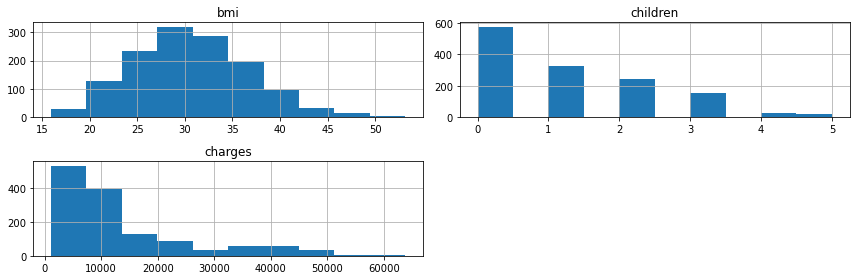

In [10]:
df.hist(figsize=(12, 4))
plt.tight_layout()

In [11]:
df.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

## Подготовка

#### Категориальные признаки

In [12]:
enc = OrdinalEncoder()
df[['is_male', 'is_smoker', 'region_enc']] = enc.fit_transform(df[['sex', 'smoker', 'region']])
df[['sex', 'is_male', 'smoker', 'is_smoker', 'region', 'region_enc']]

,sex,is_male,smoker,is_smoker,region,region_enc
age,,,,,,
19,female,0.0,yes,1.0,southwest,3.0
18,male,1.0,no,0.0,southeast,2.0
28,male,1.0,no,0.0,southeast,2.0
33,male,1.0,no,0.0,northwest,1.0
32,male,1.0,no,0.0,northwest,1.0
...,...,...,...,...,...,...
50,male,1.0,no,0.0,northwest,1.0
18,female,0.0,no,0.0,northeast,0.0
18,female,0.0,no,0.0,southeast,2.0


### Масштабирование

In [13]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
num_cols

['bmi', 'children', 'charges', 'is_male', 'is_smoker', 'region_enc']

In [14]:
df[num_cols]

,bmi,children,charges,is_male,is_smoker,region_enc
age,,,,,,
19,27.900,0,16884.92400,0.0,1.0,3.0
18,33.770,1,1725.55230,1.0,0.0,2.0
28,33.000,3,4449.46200,1.0,0.0,2.0
33,22.705,0,21984.47061,1.0,0.0,1.0
32,28.880,0,3866.85520,1.0,0.0,1.0
...,...,...,...,...,...,...
50,30.970,3,10600.54830,1.0,0.0,1.0
18,31.920,0,2205.98080,0.0,0.0,0.0
18,36.850,0,1629.83350,0.0,0.0,2.0


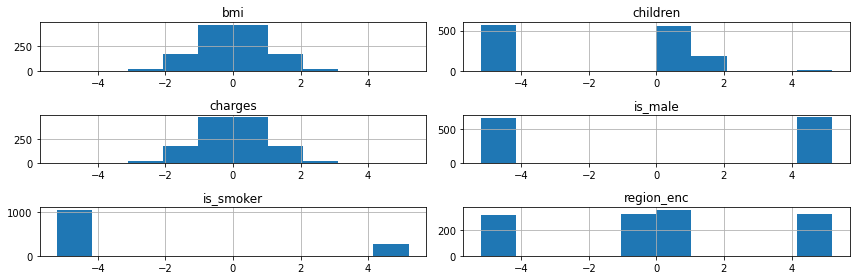

In [15]:
# df_norm = pd.DataFrame(StandardScaler().fit_transform(df[num_cols]), columns=num_cols)

norm_trans = QuantileTransformer(output_distribution='normal')
df_norm = pd.DataFrame(norm_trans.fit_transform(df[num_cols]), columns=num_cols)

df_norm.hist(figsize=(12, 4))
plt.tight_layout()

### Полезные функции / переменные

#### Colormap

In [136]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# можно заменить на любые цвета (и любое нужно количество)
# см. список цветов https://matplotlib.org/stable/gallery/color/named_colors.html
# или любой RGB

cmap_3 = ListedColormap(['fuchsia', 
                         'lime', 
                         'blue'])

cmap_4 = ListedColormap(['fuchsia',
                         'chocolate',
                         'lime', 
                         'blue'])

cmap_5 = ListedColormap(['black',
                         'fuchsia',
                         'chocolate',
                         'lime', 
                         'blue'])

cmap_7 = ListedColormap(['black', 
                         'chocolate', 
                         'fuchsia', 
                         'blue',
                         'lime', 
                         'aqua', 
                         'crimson'])

cmap_22 = ListedColormap(['black',          # 1
                          'chocolate',      # 2
                          'fuchsia',        # 3
                          'blue',           # 4
                          'lime',           # 5
                          'aqua',           # 6
                          'crimson',        # 7
                          'darkorange',     # 8
                          'deeppink',       # 9
                          'dodgerblue',     # 10
                          'darkolivegreen', # 11
                          'blueviolet',     # 12
                          'olive',          # 13
                          'tomato',         # 14
                          'purple',         # 15
                          'yellow',         # 16
                          'gold',           # 17
                          'darkgreen',      # 18
                          'teal',           # 19
                          'maroon',         # 20
                          'slategray',      # 21
                          'darkslategray']) # 22

#### Scree plot

In [17]:
def explained_variance_plot(pca_obj):
    features = range(pca_obj.n_components_)
    cumulative_sum = np.cumsum(pca_obj.explained_variance_ratio_)

    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(features)

    plt.bar(features, pca_obj.explained_variance_ratio_, align='center', label='Individual explained variance')
    plt.step(range(0,len(cumulative_sum)), cumulative_sum, where='mid',label='Cumulative explained variance')

    plt.legend(loc='best')
    plt.tight_layout()

#### Функция оценки силуэта

In [18]:
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm

def silhouette_plot(X, labels):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    # 1-й подзаголовок - это силуэтный график
    # Коэффициент силуэта может варьироваться в пределах [-1, 1], 
    # но в этом примере все лежат в пределах [-0.1, 1]
    ax.set_xlim([-0.1, 1])

    # (n_clusters+1)*10 предназначен для вставки пустого пространства 
    # между силуэтами отдельных кластеров, чтобы четко их разграничить
    n_clusters = len(set(labels))
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # silhouette_score дает среднее значение для всех выборок
    # это дает представление о плотности и разделении сформированных кластеров
    silhouette_avg = silhouette_score(X, labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # оценки силуэта для каждого образца
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # агрегация оценок силуэта для выборок, принадлежащих
        # кластеру  i и их сортировка
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.hsv(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # обозначить участки силуэта номерами кластеров в середине
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # вычислить новый y_lower для следующего участка
        y_lower = y_upper + 10  # 10 для 0 выборки

    ax.set_title("The silhouette plot for the various clusters")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # вертикальная линия для средней оценки силуэта всех значений
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    # метки осей
    ax.set_yticks([])  
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

## Визуализация данных

### N-D PCA

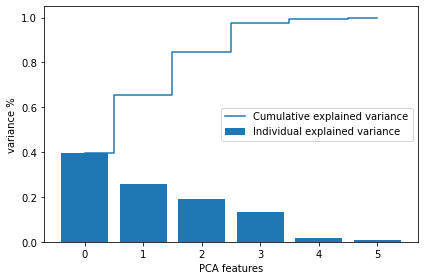

In [19]:
pca = PCA()
pca.fit(df_norm)
explained_variance_plot(pca)

### 3-D PCA

In [20]:
pca_3 = PCA(n_components=3)
df_pca_3 = pd.DataFrame(pca_3.fit_transform(df_norm))

In [21]:
%matplotlib widget

from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=-55, elev=45)

ax.scatter(df_pca_3[0], df_pca_3[1], df_pca_3[2], alpha=0.3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [22]:
%matplotlib inline

### 3-D UMAP

In [23]:
umap_3 = UMAP(n_components=3)
df_umap_3 = pd.DataFrame(umap_3.fit_transform(df_norm))

In [24]:
%matplotlib widget

from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=-55, elev=45)

ax.scatter(df_umap_3[0], df_umap_3[1], df_umap_3[2], alpha=0.3)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
%matplotlib inline

## K-means

### Выбор `n_clusters`

In [26]:
inertias = []
Ks = range(1, 25)
for k in Ks:
    km = KMeans(n_clusters=k)
    km = km.fit(df_norm)
    inertias.append(km.inertia_)

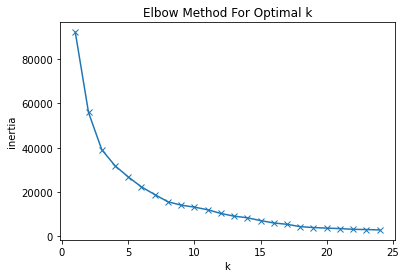

In [27]:
plt.plot(Ks, inertias, 'x-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

### Построение модели

In [28]:
kmeans_4 = KMeans(init="k-means++", 
                   n_clusters=4, 
                   n_init=15).fit(df_norm)

In [29]:
kmeans_4_clusters = kmeans_4.n_clusters
kmeans_4_labels = kmeans_4.labels_

### Анализ результатов

In [30]:
df["kmeans_4"] = kmeans_4_labels
df

,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4
age,,,,,,,,,,
19,female,27.900,0,yes,southwest,16884.92400,0.0,1.0,3.0,2
18,male,33.770,1,no,southeast,1725.55230,1.0,0.0,2.0,1
28,male,33.000,3,no,southeast,4449.46200,1.0,0.0,2.0,1
33,male,22.705,0,no,northwest,21984.47061,1.0,0.0,1.0,1
32,male,28.880,0,no,northwest,3866.85520,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...
50,male,30.970,3,no,northwest,10600.54830,1.0,0.0,1.0,1
18,female,31.920,0,no,northeast,2205.98080,0.0,0.0,0.0,0
18,female,36.850,0,no,southeast,1629.83350,0.0,0.0,2.0,0


### Оценка силуэта (Silhouette Score)

Типичные графики силуэта представляют метку кластера на оси y, а фактический показатель силуэта — на оси x.

Silhouette Score отображает меру того, **насколько близко каждая точка в кластере находится к точкам в соседних кластерах.**

**Значение силуэта показывает, насколько объект похож на свой кластер по сравнению с другими кластерами.**

**Размер/толщина силуэтов также пропорциональны количеству образцов внутри этого кластера.**

Чем выше коэффициенты силуэта (чем ближе к +1), тем дальше образцы кластера находятся от образцов соседних кластеров.

Значение 0 указывает, что образец находится на границе принятия решения между двумя соседними кластерами или очень близко к ней.

Отрицательные значения, напротив, указывают на то, что эти образцы могли быть отнесены к неправильному кластеру.

For n_clusters = 4 The average silhouette_score is : 0.4967281162223957


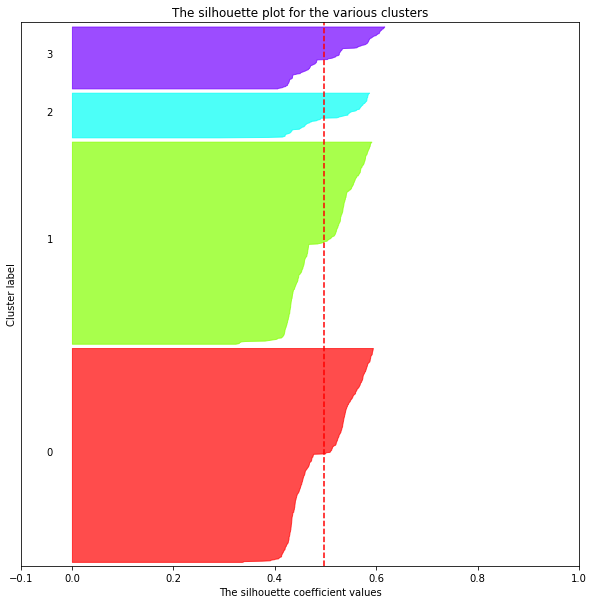

In [31]:
silhouette_plot(df_norm, kmeans_4_labels)

### 3-D PCA

In [32]:
%matplotlib widget
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=-55, elev=45)

ax.scatter(df_pca_3[0], df_pca_3[1], df_pca_3[2], 
           c=kmeans_4_labels, 
           alpha=0.3,
           s=30,
           cmap=cmap_4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [33]:
%matplotlib inline

### 3-D UMAP

In [34]:
%matplotlib widget

from mpl_toolkits.mplot3d.axes3d import Axes3D    
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=0, elev=15)

ax.scatter(df_umap_3[0], df_umap_3[1], df_umap_3[2], 
           c=kmeans_4_labels, 
           alpha=0.3,
           s=60,
           cmap=cmap_4)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [35]:
%matplotlib inline

### Анализ "представителей" кластеров

In [36]:
df.groupby('kmeans_4').mean().round(2)

,bmi,children,charges,is_male,is_smoker,region_enc
kmeans_4,,,,,,
0,30.54,1.09,8762.30,0.0,0.0,1.53
1,30.77,1.09,8087.20,1.0,0.0,1.50
2,29.61,1.01,30679.00,0.0,1.0,1.43
3,31.50,1.19,33042.01,1.0,1.0,1.57


In [37]:
df.groupby('kmeans_4').median().round(2)

,bmi,children,charges,is_male,is_smoker,region_enc
kmeans_4,,,,,,
0,30.21,1,7639.42,0.0,0.0,2.0
1,30.50,1,6985.51,1.0,0.0,2.0
2,28.38,1,28950.47,0.0,1.0,1.0
3,31.13,1,36085.22,1.0,1.0,2.0


In [38]:
clusters = {}

for c in range(kmeans_4_clusters):
    clusters[c] = df[df['kmeans_4'] == c]
    display(clusters[c])
    display(clusters[c].describe())
    print('\n', '=' * 100, '\n')

,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4
age,,,,,,,,,,
31,female,25.74,0,no,southeast,3756.62160,0.0,0.0,2.0,0
46,female,33.44,1,no,southeast,8240.58960,0.0,0.0,2.0,0
37,female,27.74,3,no,northwest,7281.50560,0.0,0.0,1.0,0
60,female,25.84,0,no,northwest,28923.13692,0.0,0.0,1.0,0
56,female,39.82,0,no,southeast,11090.71780,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...,...,...,...
23,female,33.40,0,no,southwest,10795.93733,0.0,0.0,3.0,0
52,female,44.70,3,no,southwest,11411.68500,0.0,0.0,3.0,0
18,female,31.92,0,no,northeast,2205.98080,0.0,0.0,0.0,0


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4
count,547.000000,547.000000,547.00000,547.0,547.0,547.000000,547.0
mean,30.539525,1.087751,8762.29730,0.0,0.0,1.528336,0.0
std,5.901781,1.204226,6060.77597,0.0,0.0,1.117879,0.0
min,16.815000,0.000000,1607.51010,0.0,0.0,0.000000,0.0
25%,26.357500,0.000000,4265.59910,0.0,0.0,1.000000,0.0
50%,30.210000,1.000000,7639.41745,0.0,0.0,2.000000,0.0
75%,34.307500,2.000000,11786.16660,0.0,0.0,3.000000,0.0
max,48.070000,5.000000,36910.60803,0.0,0.0,3.000000,0.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4
age,,,,,,,,,,
18,male,33.770,1,no,southeast,1725.55230,1.0,0.0,2.0,1
28,male,33.000,3,no,southeast,4449.46200,1.0,0.0,2.0,1
33,male,22.705,0,no,northwest,21984.47061,1.0,0.0,1.0,1
32,male,28.880,0,no,northwest,3866.85520,1.0,0.0,1.0,1
37,male,29.830,2,no,northeast,6406.41070,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
31,male,25.935,1,no,northwest,4239.89265,1.0,0.0,1.0,1
61,male,33.535,0,no,northeast,13143.33665,1.0,0.0,0.0,1
51,male,30.030,1,no,southeast,9377.90470,1.0,0.0,2.0,1


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4
count,517.000000,517.000000,517.000000,517.0,517.0,517.000000,517.0
mean,30.770580,1.092843,8087.204731,1.0,0.0,1.504836,1.0
std,6.192641,1.233844,5908.108989,0.0,0.0,1.106042,0.0
min,15.960000,0.000000,1121.873900,1.0,0.0,0.000000,1.0
25%,26.220000,0.000000,3659.346000,1.0,0.0,1.000000,1.0
50%,30.495000,1.000000,6985.506950,1.0,0.0,2.000000,1.0
75%,34.430000,2.000000,10959.330000,1.0,0.0,2.000000,1.0
max,53.130000,5.000000,32108.662820,1.0,0.0,3.000000,1.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4
age,,,,,,,,,,
19,female,27.900,0,yes,southwest,16884.92400,0.0,1.0,3.0,2
62,female,26.290,0,yes,southeast,27808.72510,0.0,1.0,2.0,2
34,female,31.920,1,yes,northeast,37701.87680,0.0,1.0,0.0,2
53,female,22.880,1,yes,southeast,23244.79020,0.0,1.0,2.0,2
20,female,22.420,0,yes,northwest,14711.74380,0.0,1.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...
25,female,30.200,0,yes,southwest,33900.65300,0.0,1.0,3.0,2
19,female,34.700,2,yes,southwest,36397.57600,0.0,1.0,3.0,2
30,female,23.655,3,yes,northwest,18765.87545,0.0,1.0,1.0,2


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4
count,115.000000,115.000000,115.000000,115.0,115.0,115.000000,115.0
mean,29.608261,1.008696,30678.996276,0.0,1.0,1.426087,2.0
std,6.663802,1.135516,11907.536381,0.0,0.0,1.060130,0.0
min,17.195000,0.000000,13844.506000,0.0,1.0,0.000000,2.0
25%,24.650000,0.000000,19696.432100,0.0,1.0,0.500000,2.0
50%,28.380000,1.000000,28950.469200,0.0,1.0,1.000000,2.0
75%,34.352500,2.000000,40918.314500,0.0,1.0,2.000000,2.0
max,47.600000,5.000000,63770.428010,0.0,1.0,3.000000,2.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4
age,,,,,,,,,,
27,male,42.130,0,yes,southeast,39611.75770,1.0,1.0,2.0,3
30,male,35.300,0,yes,southwest,36837.46700,1.0,1.0,3.0,3
31,male,36.300,2,yes,southwest,38711.00000,1.0,1.0,3.0,3
22,male,35.600,0,yes,southwest,35585.57600,1.0,1.0,3.0,3
28,male,36.400,1,yes,southwest,51194.55914,1.0,1.0,3.0,3
...,...,...,...,...,...,...,...,...,...,...
62,male,30.875,3,yes,northwest,46718.16325,1.0,1.0,1.0,3
43,male,27.800,0,yes,southwest,37829.72420,1.0,1.0,3.0,3
42,male,24.605,2,yes,northeast,21259.37795,1.0,1.0,0.0,3


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4
count,159.000000,159.000000,159.000000,159.0,159.0,159.000000,159.0
mean,31.504182,1.188679,33042.005975,1.0,1.0,1.572327,3.0
std,5.952028,1.170144,11202.670862,0.0,0.0,1.093474,0.0
min,17.290000,0.000000,12829.455100,1.0,1.0,0.000000,3.0
25%,27.360000,0.000000,21241.526875,1.0,1.0,1.000000,3.0
50%,31.130000,1.000000,36085.219000,1.0,1.0,2.000000,3.0
75%,35.565000,2.000000,41797.589050,1.0,1.0,2.000000,3.0
max,52.580000,4.000000,62592.873090,1.0,1.0,3.000000,3.0


### <Проверка гипотез / Дополнительные графики / Выводы>

Этот раздел необходимо назвать самостоятельно.

Можно разделить на несколько разделов. 

Написать выводы, идеи и т.п., чтобы было понятно, что пытались проанализировать кластеры.

In [39]:
df

,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4
age,,,,,,,,,,
19,female,27.900,0,yes,southwest,16884.92400,0.0,1.0,3.0,2
18,male,33.770,1,no,southeast,1725.55230,1.0,0.0,2.0,1
28,male,33.000,3,no,southeast,4449.46200,1.0,0.0,2.0,1
33,male,22.705,0,no,northwest,21984.47061,1.0,0.0,1.0,1
32,male,28.880,0,no,northwest,3866.85520,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...
50,male,30.970,3,no,northwest,10600.54830,1.0,0.0,1.0,1
18,female,31.920,0,no,northeast,2205.98080,0.0,0.0,0.0,0
18,female,36.850,0,no,southeast,1629.83350,0.0,0.0,2.0,0


In [180]:
%matplotlib widget
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=-75, elev=30)


ax.scatter(df.is_male, df.is_smoker, df.region_enc, 
           c=df['kmeans_4'],
           alpha=0.5, 
           s=60, 
           cmap=cmap_4)

ax.set_xlabel('is_male')
ax.set_ylabel('is_smoker')
ax.set_zlabel('region_enc')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'region_enc')

In [41]:
%matplotlib inline

## DBSCAN

ВНИМАНИЕ: нормально, если получится много кластеров (~20), можно попробовать сделать меньше, провести различные эксперименты с `min_samples` и `eps`.

### Выбор `min_samples`

In [155]:
min_samples = len(df_norm.columns) + 4
min_samples

10

### Выбор `eps`

In [156]:
# рассчитать среднее расстояние между каждой точкой 
# в наборе данных и ее min_samples ближайшими соседями 
neighbors = NearestNeighbors(n_neighbors=min_samples-1)
neighbors_fit = neighbors.fit(df_norm)
distances, indices = neighbors_fit.kneighbors(df_norm)

In [157]:
# сортировка значений расстояний по возрастанию и построение графика
distances = np.sort(distances, axis=0)

In [158]:
distances = distances[:, 1]

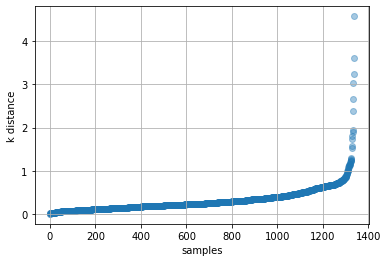

In [159]:
# оптимальное значение для epsilon будет найдено 
# в точке максимальной кривизны
plt.scatter(x=range(len(df_norm)), y=distances, alpha=0.4)

plt.xlabel('samples')
plt.ylabel('k distance')
plt.grid(True)

In [163]:
epsilon = 1.35

### Построение модели

<AxesSubplot:ylabel='count'>

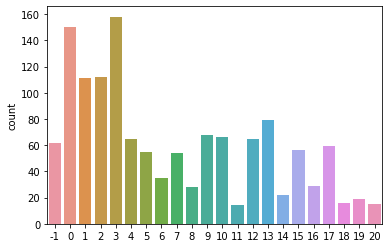

In [164]:
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples).fit(df_norm)
dbscan_labels = dbscan.labels_
sns.countplot(x=dbscan_labels)

### Анализ результатов

In [176]:
dbscan_clusters = np.unique(dbscan_labels).tolist()
dbscan_clusters

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [165]:
df["dbscan"] = dbscan_labels
df

,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
19,female,27.900,0,yes,southwest,16884.92400,0.0,1.0,3.0,2,-1
18,male,33.770,1,no,southeast,1725.55230,1.0,0.0,2.0,1,0
28,male,33.000,3,no,southeast,4449.46200,1.0,0.0,2.0,1,0
33,male,22.705,0,no,northwest,21984.47061,1.0,0.0,1.0,1,1
32,male,28.880,0,no,northwest,3866.85520,1.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
50,male,30.970,3,no,northwest,10600.54830,1.0,0.0,1.0,1,0
18,female,31.920,0,no,northeast,2205.98080,0.0,0.0,0.0,0,12
18,female,36.850,0,no,southeast,1629.83350,0.0,0.0,2.0,0,2


### Оценка силуэта (Silhouette Score)

Типичные графики силуэта представляют метку кластера на оси y, а фактический показатель силуэта — на оси x.

Silhouette Score отображает меру того, **насколько близко каждая точка в кластере находится к точкам в соседних кластерах.**

**Значение силуэта показывает, насколько объект похож на свой кластер по сравнению с другими кластерами.**

**Размер/толщина силуэтов также пропорциональны количеству образцов внутри этого кластера.**

Чем выше коэффициенты силуэта (чем ближе к +1), тем дальше образцы кластера находятся от образцов соседних кластеров.

Значение 0 указывает, что образец находится на границе принятия решения между двумя соседними кластерами или очень близко к ней.

Отрицательные значения, напротив, указывают на то, что эти образцы могли быть отнесены к неправильному кластеру.

For n_clusters = 22 The average silhouette_score is : 0.6331969580078848


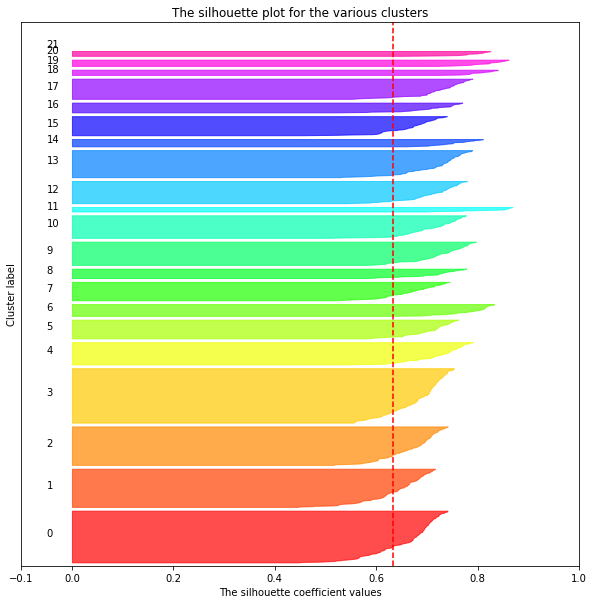

In [166]:
silhouette_plot(df_norm, dbscan_labels)

### 3-D PCA

In [167]:
%matplotlib widget
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=-55, elev=45)

ax.scatter(df_pca_3[0], df_pca_3[1], df_pca_3[2], 
           c=dbscan_labels, 
           alpha=0.3,
           s=30,
           cmap=cmap_22)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [168]:
%matplotlib inline

### 3-D UMAP

In [169]:
%matplotlib widget

from mpl_toolkits.mplot3d.axes3d import Axes3D    
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=0, elev=15)

ax.scatter(df_umap_3[0], df_umap_3[1], df_umap_3[2], 
           c=kmeans_4_labels, 
           alpha=0.3,
           s=60,
           cmap=cmap_22)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [170]:
%matplotlib inline

### Анализ "представителей" кластеров

In [171]:
df.groupby('dbscan').mean().round(2)

,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4
dbscan,,,,,,,
-1,30.75,2.11,24436.75,0.29,0.65,1.71,1.58
0,31.56,1.77,8690.25,1.00,0.00,1.47,1.00
1,31.51,0.00,7037.78,1.00,0.00,1.52,1.00
2,31.08,0.00,7655.07,0.00,0.00,1.51,0.00
3,31.18,1.83,9261.57,0.00,0.00,1.50,0.00
4,28.19,1.91,9182.32,1.00,0.00,0.00,1.00
5,29.66,0.00,8073.19,1.00,0.00,0.00,1.00
6,31.05,0.00,31840.39,0.00,1.00,1.51,2.00
7,30.21,0.00,8336.50,1.00,0.00,3.00,1.00


In [172]:
df.groupby('dbscan').median().round(2)

,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4
dbscan,,,,,,,
-1,30.49,2.0,18815.76,0.0,1.0,2.0,2
0,31.26,2.0,6753.53,1.0,0.0,1.0,1
1,31.54,0.0,5438.75,1.0,0.0,2.0,1
2,31.14,0.0,5399.30,0.0,0.0,2.0,0
3,30.45,2.0,7738.20,0.0,0.0,1.5,0
4,27.64,2.0,8334.46,1.0,0.0,0.0,1
5,28.88,0.0,8688.86,1.0,0.0,0.0,1
6,29.81,0.0,29330.98,0.0,1.0,2.0,2
7,30.35,0.0,8451.15,1.0,0.0,3.0,1


In [178]:
clusters = {}

for c in dbscan_clusters:
    clusters[c] = df[df['dbscan'] == c]
    display(clusters[c])
    display(clusters[c].describe())
    print('\n', '=' * 100, '\n')

,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
19,female,27.90,0,yes,southwest,16884.92400,0.0,1.0,3.0,2,-1
19,female,28.60,5,no,southwest,4687.79700,0.0,0.0,3.0,0,-1
31,male,28.50,5,no,northeast,6799.45800,1.0,0.0,0.0,1,-1
37,female,34.80,2,yes,southwest,39836.51900,0.0,1.0,3.0,2,-1
64,female,31.30,2,yes,southwest,47291.05500,0.0,1.0,3.0,2,-1
...,...,...,...,...,...,...,...,...,...,...,...
29,female,21.85,0,yes,northeast,16115.30450,0.0,1.0,0.0,2,-1
25,female,30.20,0,yes,southwest,33900.65300,0.0,1.0,3.0,2,-1
19,female,34.70,2,yes,southwest,36397.57600,0.0,1.0,3.0,2,-1


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.0
mean,30.753226,2.112903,24436.749777,0.290323,0.645161,1.709677,1.580645,-1.0
std,8.266913,2.081179,17180.573890,0.457617,0.482370,1.383594,0.800581,0.0
min,15.960000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,-1.0
25%,24.243750,0.000000,9364.018425,0.000000,0.000000,0.000000,1.000000,-1.0
50%,30.490000,2.000000,18815.761000,0.000000,1.000000,2.000000,2.000000,-1.0
75%,36.171250,5.000000,40637.279375,1.000000,1.000000,3.000000,2.000000,-1.0
max,53.130000,5.000000,63770.428010,1.000000,1.000000,3.000000,3.000000,-1.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
18,male,33.770,1,no,southeast,1725.55230,1.0,0.0,2.0,1,0
28,male,33.000,3,no,southeast,4449.46200,1.0,0.0,2.0,1,0
37,male,28.025,2,no,northwest,6203.90175,1.0,0.0,1.0,1,0
23,male,17.385,1,no,northwest,2775.19215,1.0,0.0,1.0,1,0
41,male,21.780,1,no,southeast,6272.47720,1.0,0.0,2.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
42,male,26.315,1,no,northwest,6940.90985,1.0,0.0,1.0,1,0
31,male,31.065,3,no,northwest,5425.02335,1.0,0.0,1.0,1,0
31,male,25.935,1,no,northwest,4239.89265,1.0,0.0,1.0,1,0


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,150.000000,150.000000,150.000000,150.0,150.0,150.000000,150.0,150.0
mean,31.563767,1.773333,8690.252787,1.0,0.0,1.473333,1.0,0.0
std,6.502585,0.836633,6257.081065,0.0,0.0,0.500961,0.0,0.0
min,17.385000,1.000000,1711.026800,1.0,0.0,1.000000,1.0,0.0
25%,27.288750,1.000000,4676.641325,1.0,0.0,1.000000,1.0,0.0
50%,31.255000,2.000000,6753.527575,1.0,0.0,1.000000,1.0,0.0
75%,34.685000,2.000000,10590.534150,1.0,0.0,2.000000,1.0,0.0
max,50.380000,4.000000,30284.642940,1.0,0.0,2.000000,1.0,0.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
33,male,22.705,0,no,northwest,21984.47061,1.0,0.0,1.0,1,1
32,male,28.880,0,no,northwest,3866.85520,1.0,0.0,1.0,1,1
18,male,34.100,0,no,southeast,1137.01100,1.0,0.0,2.0,1,1
63,male,28.310,0,no,northwest,13770.09790,1.0,0.0,1.0,1,1
19,male,20.425,0,no,northwest,1625.43375,1.0,0.0,1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
56,male,34.430,0,no,southeast,10594.22570,1.0,0.0,2.0,1,1
26,male,31.065,0,no,northwest,2699.56835,1.0,0.0,1.0,1,1
18,male,33.330,0,no,southeast,1135.94070,1.0,0.0,2.0,1,1


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,111.000000,111.0,111.000000,111.0,111.0,111.000000,111.0,111.0
mean,31.513468,0.0,7037.776861,1.0,0.0,1.522523,1.0,1.0
std,6.061561,0.0,5914.095662,0.0,0.0,0.501758,0.0,0.0
min,17.480000,0.0,1131.506600,1.0,0.0,1.000000,1.0,1.0
25%,27.597500,0.0,1871.820075,1.0,0.0,1.000000,1.0,1.0
50%,31.540000,0.0,5438.749100,1.0,0.0,2.000000,1.0,1.0
75%,35.577500,0.0,11167.864450,1.0,0.0,2.000000,1.0,1.0
max,49.060000,0.0,27346.042070,1.0,0.0,2.000000,1.0,1.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
31,female,25.740,0,no,southeast,3756.62160,0.0,0.0,2.0,0,2
60,female,25.840,0,no,northwest,28923.13692,0.0,0.0,1.0,0,2
56,female,39.820,0,no,southeast,11090.71780,0.0,0.0,2.0,0,2
28,female,34.770,0,no,northwest,3556.92230,0.0,0.0,1.0,0,2
60,female,24.530,0,no,southeast,12629.89670,0.0,0.0,2.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...
32,female,29.735,0,no,northwest,4357.04365,0.0,0.0,1.0,0,2
48,female,33.330,0,no,southeast,8283.68070,0.0,0.0,2.0,0,2
24,female,27.720,0,no,southeast,2464.61880,0.0,0.0,2.0,0,2


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,112.000000,112.0,112.000000,112.0,112.0,112.000000,112.0,112.0
mean,31.083080,0.0,7655.069281,0.0,0.0,1.508929,0.0,2.0
std,5.964374,0.0,6014.669146,0.0,0.0,0.502167,0.0,0.0
min,18.050000,0.0,1607.510100,0.0,0.0,1.000000,0.0,2.0
25%,26.615000,0.0,2516.108763,0.0,0.0,1.000000,0.0,2.0
50%,31.145000,0.0,5399.298600,0.0,0.0,2.000000,0.0,2.0
75%,35.853750,0.0,11846.070687,0.0,0.0,2.000000,0.0,2.0
max,44.220000,0.0,28923.136920,0.0,0.0,2.000000,0.0,2.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
46,female,33.440,1,no,southeast,8240.58960,0.0,0.0,2.0,0,3
37,female,27.740,3,no,northwest,7281.50560,0.0,0.0,1.0,0,3
59,female,27.720,3,no,southeast,14001.13380,0.0,0.0,2.0,0,3
55,female,32.775,2,no,northwest,12268.63225,0.0,0.0,1.0,0,3
62,female,32.965,3,no,northwest,15612.19335,0.0,0.0,1.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
25,female,26.790,2,no,northwest,4189.11310,0.0,0.0,1.0,0,3
28,female,26.510,2,no,southeast,4340.44090,0.0,0.0,2.0,0,3
19,female,25.745,1,no,northwest,2710.82855,0.0,0.0,1.0,0,3


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,158.000000,158.000000,158.000000,158.0,158.0,158.00000,158.0,158.0
mean,31.183070,1.829114,9261.570719,0.0,0.0,1.50000,0.0,3.0
std,5.747983,0.868361,6192.149273,0.0,0.0,0.50159,0.0,0.0
min,19.475000,1.000000,2201.097100,0.0,0.0,1.00000,0.0,3.0
25%,27.663750,1.000000,4929.626600,0.0,0.0,1.00000,0.0,3.0
50%,30.447500,2.000000,7738.204800,0.0,0.0,1.50000,0.0,3.0
75%,35.140000,2.000000,11029.039950,0.0,0.0,2.00000,0.0,3.0
max,46.090000,4.000000,36580.282160,0.0,0.0,2.00000,0.0,3.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
37,male,29.830,2,no,northeast,6406.41070,1.0,0.0,0.0,1,4
38,male,37.050,1,no,northeast,6079.67150,1.0,0.0,0.0,1,4
43,male,27.360,3,no,northeast,8606.21740,1.0,0.0,0.0,1,4
31,male,26.885,1,no,northeast,4441.21315,1.0,0.0,0.0,1,4
52,male,32.205,3,no,northeast,11488.31695,1.0,0.0,0.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...
51,male,32.300,1,no,northeast,9964.06000,1.0,0.0,0.0,1,4
41,male,23.940,1,no,northeast,6858.47960,1.0,0.0,0.0,1,4
38,male,16.815,2,no,northeast,6640.54485,1.0,0.0,0.0,1,4


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,65.000000,65.000000,65.000000,65.0,65.0,65.0,65.0,65.0
mean,28.191615,1.907692,9182.324937,1.0,0.0,0.0,1.0,4.0
std,5.165639,0.930777,6058.813762,0.0,0.0,0.0,0.0,0.0
min,16.815000,1.000000,3279.868550,1.0,0.0,0.0,1.0,4.0
25%,24.985000,1.000000,5031.269550,1.0,0.0,0.0,1.0,4.0
50%,27.645000,2.000000,8334.457550,1.0,0.0,0.0,1.0,4.0
75%,32.110000,3.000000,9964.060000,1.0,0.0,0.0,1.0,4.0
max,41.230000,4.000000,32108.662820,1.0,0.0,0.0,1.0,4.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
25,male,26.220,0,no,northeast,2721.32080,1.0,0.0,0.0,1,5
23,male,23.845,0,no,northeast,2395.17155,1.0,0.0,0.0,1,5
30,male,25.460,0,no,northeast,3645.08940,1.0,0.0,0.0,1,5
60,male,28.595,0,no,northeast,30259.99556,1.0,0.0,0.0,1,5
18,male,23.750,0,no,northeast,1705.62450,1.0,0.0,0.0,1,5
18,male,22.990,0,no,northeast,1704.56810,1.0,0.0,0.0,1,5
58,male,34.865,0,no,northeast,11944.59435,1.0,0.0,0.0,1,5
52,male,33.250,0,no,northeast,9722.76950,1.0,0.0,0.0,1,5
54,male,32.775,0,no,northeast,10435.06525,1.0,0.0,0.0,1,5


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,55.000000,55.0,55.000000,55.0,55.0,55.0,55.0,55.0
mean,29.660727,0.0,8073.194925,1.0,0.0,0.0,1.0,5.0
std,5.904869,0.0,5903.436937,0.0,0.0,0.0,0.0,0.0
min,18.335000,0.0,1702.455300,1.0,0.0,0.0,1.0,5.0
25%,25.317500,0.0,2395.633725,1.0,0.0,0.0,1.0,5.0
50%,28.880000,0.0,8688.858850,1.0,0.0,0.0,1.0,5.0
75%,33.725000,0.0,12364.407550,1.0,0.0,0.0,1.0,5.0
max,42.655000,0.0,30259.995560,1.0,0.0,0.0,1.0,5.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
62,female,26.290,0,yes,southeast,27808.72510,0.0,1.0,2.0,2,6
20,female,22.420,0,yes,northwest,14711.74380,0.0,1.0,1.0,2,6
27,female,24.750,0,yes,southeast,16577.77950,0.0,1.0,2.0,2,6
57,female,31.160,0,yes,northwest,43578.93940,0.0,1.0,1.0,2,6
42,female,26.600,0,yes,northwest,21348.70600,0.0,1.0,1.0,2,6
18,female,36.850,0,yes,southeast,36149.48350,0.0,1.0,2.0,2,6
27,female,36.080,0,yes,southeast,37133.89820,0.0,1.0,2.0,2,6
23,female,28.310,0,yes,northwest,18033.96790,0.0,1.0,1.0,2,6
63,female,26.980,0,yes,northwest,28950.46920,0.0,1.0,1.0,2,6


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,35.000000,35.0,35.000000,35.0,35.0,35.000000,35.0,35.0
mean,31.051714,0.0,31840.388299,0.0,1.0,1.514286,2.0,6.0
std,5.732700,0.0,10736.008568,0.0,0.0,0.507093,0.0,0.0
min,22.420000,0.0,14711.743800,0.0,1.0,1.000000,2.0,6.0
25%,26.885000,0.0,22419.871425,0.0,1.0,1.000000,2.0,6.0
50%,29.810000,0.0,29330.983150,0.0,1.0,2.000000,2.0,6.0
75%,35.365000,0.0,40696.592000,0.0,1.0,2.000000,2.0,6.0
max,46.200000,0.0,55135.402090,0.0,1.0,2.000000,2.0,6.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
23,male,34.4,0,no,southwest,1826.84300,1.0,0.0,3.0,1,7
56,male,40.3,0,no,southwest,10602.38500,1.0,0.0,3.0,1,7
26,male,20.8,0,no,southwest,2302.30000,1.0,0.0,3.0,1,7
55,male,37.3,0,no,southwest,20630.28351,1.0,0.0,3.0,1,7
37,male,30.8,0,no,southwest,4646.75900,1.0,0.0,3.0,1,7
19,male,34.1,0,no,southwest,1261.44200,1.0,0.0,3.0,1,7
49,male,30.3,0,no,southwest,8116.68000,1.0,0.0,3.0,1,7
46,male,22.3,0,no,southwest,7147.10500,1.0,0.0,3.0,1,7
50,male,26.6,0,no,southwest,8444.47400,1.0,0.0,3.0,1,7


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,54.000000,54.0,54.000000,54.0,54.0,54.0,54.0,54.0
mean,30.211111,0.0,8336.496361,1.0,0.0,3.0,1.0,7.0
std,6.025188,0.0,6479.402336,0.0,0.0,0.0,0.0,0.0
min,19.800000,0.0,1241.565000,1.0,0.0,3.0,1.0,7.0
25%,26.000000,0.0,1974.166250,1.0,0.0,3.0,1.0,7.0
50%,30.350000,0.0,8451.146000,1.0,0.0,3.0,1.0,7.0
75%,34.475000,0.0,11365.152750,1.0,0.0,3.0,1.0,7.0
max,43.400000,0.0,24603.048370,1.0,0.0,3.0,1.0,7.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
27,male,42.130,0,yes,southeast,39611.75770,1.0,1.0,2.0,3,8
36,male,34.430,0,yes,southeast,37742.57570,1.0,1.0,2.0,3,8
63,male,35.090,0,yes,southeast,47055.53210,1.0,1.0,2.0,3,8
48,male,24.420,0,yes,southeast,21223.67580,1.0,1.0,2.0,3,8
30,male,35.530,0,yes,southeast,36950.25670,1.0,1.0,2.0,3,8
42,male,24.640,0,yes,southeast,19515.54160,1.0,1.0,2.0,3,8
19,male,29.070,0,yes,northwest,17352.68030,1.0,1.0,1.0,3,8
56,male,33.630,0,yes,northwest,43921.18370,1.0,1.0,1.0,3,8
19,male,31.920,0,yes,northwest,33750.29180,1.0,1.0,1.0,3,8


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,28.000000,28.0,28.000000,28.0,28.0,28.000000,28.0,28.0
mean,32.172321,0.0,32944.141087,1.0,1.0,1.750000,3.0,8.0
std,6.064678,0.0,12254.483380,0.0,0.0,0.440959,0.0,0.0
min,20.900000,0.0,15817.985700,1.0,1.0,1.000000,3.0,8.0
25%,28.215000,0.0,20775.748900,1.0,1.0,1.750000,3.0,8.0
50%,31.800000,0.0,35445.776325,1.0,1.0,2.000000,3.0,8.0
75%,35.942500,0.0,40211.079925,1.0,1.0,2.000000,3.0,8.0
max,44.880000,0.0,62592.873090,1.0,1.0,2.000000,3.0,8.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
19,male,24.6,1,no,southwest,1837.237,1.0,0.0,3.0,1,9
44,male,27.4,2,no,southwest,7726.854,1.0,0.0,3.0,1,9
44,male,37.1,2,no,southwest,7740.337,1.0,0.0,3.0,1,9
38,male,34.7,2,no,southwest,6082.405,1.0,0.0,3.0,1,9
19,male,28.4,1,no,southwest,1842.519,1.0,0.0,3.0,1,9
...,...,...,...,...,...,...,...,...,...,...,...
45,male,27.5,3,no,southwest,8615.300,1.0,0.0,3.0,1,9
20,male,22.0,1,no,southwest,1964.780,1.0,0.0,3.0,1,9
41,male,32.2,2,no,southwest,6875.961,1.0,0.0,3.0,1,9


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,68.000000,68.000000,68.000000,68.0,68.0,68.0,68.0,68.0
mean,31.775000,1.779412,7389.891409,1.0,0.0,3.0,1.0,9.0
std,5.465615,0.895188,4293.954801,0.0,0.0,0.0,0.0,0.0
min,20.900000,1.000000,1832.094000,1.0,0.0,3.0,1.0,9.0
25%,28.675000,1.000000,4033.904500,1.0,0.0,3.0,1.0,9.0
50%,31.200000,1.500000,7178.480500,1.0,0.0,3.0,1.0,9.0
75%,35.875000,2.250000,9809.750750,1.0,0.0,3.0,1.0,9.0
max,45.900000,4.000000,27941.287580,1.0,0.0,3.0,1.0,9.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
52,female,30.780,1,no,northeast,10797.33620,0.0,0.0,0.0,0,10
18,female,38.665,2,no,northeast,3393.35635,0.0,0.0,0.0,0,10
58,female,31.825,2,no,northeast,13607.36875,0.0,0.0,0.0,0,10
32,female,37.145,3,no,northeast,6334.34355,0.0,0.0,0.0,0,10
40,female,25.460,1,no,northeast,7077.18940,0.0,0.0,0.0,0,10
...,...,...,...,...,...,...,...,...,...,...,...
58,female,32.395,1,no,northeast,13019.16105,0.0,0.0,0.0,0,10
30,female,21.945,1,no,northeast,4718.20355,0.0,0.0,0.0,0,10
49,female,33.345,2,no,northeast,10370.91255,0.0,0.0,0.0,0,10


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,66.000000,66.000000,66.000000,66.0,66.0,66.0,66.0,66.0
mean,30.139470,1.893939,11187.001223,0.0,0.0,0.0,0.0,10.0
std,5.936101,0.879314,6350.682826,0.0,0.0,0.0,0.0,0.0
min,17.290000,1.000000,3393.356350,0.0,0.0,0.0,0.0,10.0
25%,25.388750,1.000000,6927.782425,0.0,0.0,0.0,0.0,10.0
50%,31.065000,2.000000,9447.316375,0.0,0.0,0.0,0.0,10.0
75%,33.226250,2.000000,13378.713013,0.0,0.0,0.0,0.0,10.0
max,48.070000,4.000000,31620.001060,0.0,0.0,0.0,0.0,10.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
30,male,35.3,0,yes,southwest,36837.46700,1.0,1.0,3.0,3,11
22,male,35.6,0,yes,southwest,35585.57600,1.0,1.0,3.0,3,11
60,male,39.9,0,yes,southwest,48173.36100,1.0,1.0,3.0,3,11
19,male,34.8,0,yes,southwest,34779.61500,1.0,1.0,3.0,3,11
19,male,27.7,0,yes,southwest,16297.84600,1.0,1.0,3.0,3,11
34,male,30.8,0,yes,southwest,35491.64000,1.0,1.0,3.0,3,11
42,male,30.0,0,yes,southwest,22144.03200,1.0,1.0,3.0,3,11
29,male,34.4,0,yes,southwest,36197.69900,1.0,1.0,3.0,3,11
24,male,32.7,0,yes,southwest,34472.84100,1.0,1.0,3.0,3,11


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,14.000000,14.0,14.000000,14.0,14.0,14.0,14.0,14.0
mean,32.492857,0.0,34370.696114,1.0,1.0,3.0,3.0,11.0
std,3.625437,0.0,10306.054144,0.0,0.0,0.0,0.0,0.0
min,27.300000,0.0,16232.847000,1.0,1.0,3.0,3.0,11.0
25%,30.200000,0.0,34549.534500,1.0,1.0,3.0,3.0,11.0
50%,32.750000,0.0,35538.608000,1.0,1.0,3.0,3.0,11.0
75%,34.875000,0.0,37581.659900,1.0,1.0,3.0,3.0,11.0
max,39.900000,0.0,52590.829390,1.0,1.0,3.0,3.0,11.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
60,female,36.005,0,no,northeast,13228.84695,0.0,0.0,0.0,0,12
63,female,23.085,0,no,northeast,14451.83515,0.0,0.0,0.0,0,12
18,female,26.315,0,no,northeast,2198.18985,0.0,0.0,0.0,0,12
24,female,26.600,0,no,northeast,3046.06200,0.0,0.0,0.0,0,12
18,female,35.625,0,no,northeast,2211.13075,0.0,0.0,0.0,0,12
...,...,...,...,...,...,...,...,...,...,...,...
22,female,30.400,0,no,northeast,2741.94800,0.0,0.0,0.0,0,12
47,female,24.320,0,no,northeast,8534.67180,0.0,0.0,0.0,0,12
28,female,17.290,0,no,northeast,3732.62510,0.0,0.0,0.0,0,12


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,65.000000,65.0,65.000000,65.0,65.0,65.0,65.0,65.0
mean,29.609308,0.0,8169.643466,0.0,0.0,0.0,0.0,12.0
std,6.056369,0.0,5903.371200,0.0,0.0,0.0,0.0,0.0
min,17.290000,0.0,2196.473200,0.0,0.0,0.0,0.0,12.0
25%,25.175000,0.0,2899.489350,0.0,0.0,0.0,0.0,12.0
50%,28.785000,0.0,7050.021300,0.0,0.0,0.0,0.0,12.0
75%,33.155000,0.0,12430.953350,0.0,0.0,0.0,0.0,12.0
max,44.745000,0.0,25656.575260,0.0,0.0,0.0,0.0,12.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
30,female,32.4,1,no,southwest,4149.73600,0.0,0.0,3.0,0,13
61,female,39.1,2,no,southwest,14235.07200,0.0,0.0,3.0,0,13
53,female,28.1,3,no,southwest,11741.72600,0.0,0.0,3.0,0,13
54,female,30.8,3,no,southwest,12105.32000,0.0,0.0,3.0,0,13
34,female,27.5,1,no,southwest,5003.85300,0.0,0.0,3.0,0,13
...,...,...,...,...,...,...,...,...,...,...,...
40,female,29.3,4,no,southwest,15828.82173,0.0,0.0,3.0,0,13
43,female,29.9,1,no,southwest,7337.74800,0.0,0.0,3.0,0,13
36,female,25.9,1,no,southwest,5472.44900,0.0,0.0,3.0,0,13


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,79.000000,79.000000,79.000000,79.0,79.0,79.0,79.0,79.0
mean,30.065823,1.835443,9036.542655,0.0,0.0,3.0,0.0,13.0
std,5.773056,0.897723,6258.253809,0.0,0.0,0.0,0.0,0.0
min,17.400000,1.000000,2331.519000,0.0,0.0,3.0,0.0,13.0
25%,25.850000,1.000000,5243.406000,0.0,0.0,3.0,0.0,13.0
50%,29.800000,2.000000,7623.518000,0.0,0.0,3.0,0.0,13.0
75%,33.900000,2.500000,11157.174000,0.0,0.0,3.0,0.0,13.0
max,46.700000,4.000000,36910.608030,0.0,0.0,3.0,0.0,13.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
31,male,36.3,2,yes,southwest,38711.00000,1.0,1.0,3.0,3,14
28,male,36.4,1,yes,southwest,51194.55914,1.0,1.0,3.0,3,14
48,male,28.0,1,yes,southwest,23568.27200,1.0,1.0,3.0,3,14
50,male,34.2,2,yes,southwest,42856.83800,1.0,1.0,3.0,3,14
26,male,32.9,2,yes,southwest,36085.21900,1.0,1.0,3.0,3,14
54,male,25.1,3,yes,southwest,25382.29700,1.0,1.0,3.0,3,14
21,male,25.7,4,yes,southwest,17942.10600,1.0,1.0,3.0,3,14
39,male,28.3,1,yes,southwest,21082.16000,1.0,1.0,3.0,3,14
30,male,37.8,2,yes,southwest,39241.44200,1.0,1.0,3.0,3,14


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,22.000000,22.000000,22.000000,22.0,22.0,22.0,22.0,22.0
mean,31.427273,2.181818,32233.976410,1.0,1.0,3.0,3.0,14.0
std,4.695406,0.906924,10858.815045,0.0,0.0,0.0,0.0,0.0
min,24.400000,1.000000,17942.106000,1.0,1.0,3.0,3.0,14.0
25%,27.325000,2.000000,21638.256750,1.0,1.0,3.0,3.0,14.0
50%,31.550000,2.000000,37214.892500,1.0,1.0,3.0,3.0,14.0
75%,35.450000,3.000000,39888.278000,1.0,1.0,3.0,3.0,14.0
max,39.400000,4.000000,51194.559140,1.0,1.0,3.0,3.0,14.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
36,male,35.200,1,yes,southeast,38709.17600,1.0,1.0,2.0,3,15
58,male,36.955,2,yes,northwest,47496.49445,1.0,1.0,1.0,3,15
18,male,31.680,2,yes,southeast,34303.16720,1.0,1.0,2.0,3,15
28,male,23.980,3,yes,southeast,17663.14420,1.0,1.0,2.0,3,15
22,male,37.620,1,yes,southeast,37165.16380,1.0,1.0,2.0,3,15
45,male,22.895,2,yes,northwest,21098.55405,1.0,1.0,1.0,3,15
20,male,28.025,1,yes,northwest,17560.37975,1.0,1.0,1.0,3,15
34,male,25.300,2,yes,southeast,18972.49500,1.0,1.0,2.0,3,15
30,male,28.690,3,yes,northwest,20745.98910,1.0,1.0,1.0,3,15


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,56.000000,56.000000,56.000000,56.0,56.0,56.000000,56.0,56.0
mean,32.490357,1.910714,34819.419212,1.0,1.0,1.607143,3.0,15.0
std,6.877769,0.837242,11459.600817,0.0,0.0,0.492805,0.0,0.0
min,19.800000,1.000000,16450.894700,1.0,1.0,1.000000,3.0,15.0
25%,27.550000,1.000000,22158.255400,1.0,1.0,1.000000,3.0,15.0
50%,31.735000,2.000000,38264.171385,1.0,1.0,2.000000,3.0,15.0
75%,36.987500,3.000000,43911.062975,1.0,1.0,2.000000,3.0,15.0
max,52.580000,4.000000,60021.398970,1.0,1.0,2.000000,3.0,15.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
53,female,22.880,1,yes,southeast,23244.79020,0.0,1.0,2.0,2,16
61,female,29.920,3,yes,southeast,30942.19180,0.0,1.0,2.0,2,16
29,female,27.940,1,yes,southeast,19107.77960,0.0,1.0,2.0,2,16
32,female,17.765,2,yes,northwest,32734.18630,0.0,1.0,1.0,2,16
40,female,22.220,2,yes,southeast,19444.26580,0.0,1.0,2.0,2,16
20,female,26.840,1,yes,southeast,17085.26760,0.0,1.0,2.0,2,16
30,female,28.380,1,yes,southeast,19521.96820,0.0,1.0,2.0,2,16
35,female,34.105,3,yes,northwest,39983.42595,0.0,1.0,1.0,2,16
34,female,30.210,1,yes,northwest,43943.87610,0.0,1.0,1.0,2,16


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,29.000000,29.000000,29.000000,29.0,29.0,29.000000,29.0,29.0
mean,29.222069,2.000000,30052.532784,0.0,1.0,1.586207,2.0,16.0
std,6.183166,0.845154,10535.211448,0.0,0.0,0.501230,0.0,0.0
min,17.765000,1.000000,16420.494550,0.0,1.0,1.000000,2.0,16.0
25%,24.700000,1.000000,19521.968200,0.0,1.0,1.000000,2.0,16.0
50%,28.380000,2.000000,24667.419000,0.0,1.0,2.000000,2.0,16.0
75%,32.775000,3.000000,40003.332250,0.0,1.0,2.000000,2.0,16.0
max,43.890000,3.000000,46661.442400,0.0,1.0,2.000000,2.0,16.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
19,female,28.9,0,no,southwest,1743.21400,0.0,0.0,3.0,0,17
56,female,27.2,0,no,southwest,11073.17600,0.0,0.0,3.0,0,17
41,female,31.6,0,no,southwest,6186.12700,0.0,0.0,3.0,0,17
52,female,37.4,0,no,southwest,9634.53800,0.0,0.0,3.0,0,17
22,female,36.0,0,no,southwest,2166.73200,0.0,0.0,3.0,0,17
36,female,26.2,0,no,southwest,4883.86600,0.0,0.0,3.0,0,17
39,female,32.8,0,no,southwest,5649.71500,0.0,0.0,3.0,0,17
63,female,31.8,0,no,southwest,13880.94900,0.0,0.0,3.0,0,17
19,female,17.8,0,no,southwest,1727.78500,0.0,0.0,3.0,0,17


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,59.000000,59.0,59.000000,59.0,59.0,59.0,59.0,59.0
mean,29.905085,0.0,7221.163847,0.0,0.0,3.0,0.0,17.0
std,5.633044,0.0,4724.238363,0.0,0.0,0.0,0.0,0.0
min,17.800000,0.0,1727.785000,0.0,0.0,3.0,0.0,17.0
25%,25.850000,0.0,2312.117000,0.0,0.0,3.0,0.0,17.0
50%,29.100000,0.0,6474.013000,0.0,0.0,3.0,0.0,17.0
75%,33.250000,0.0,11646.220000,0.0,0.0,3.0,0.0,17.0
max,44.000000,0.0,18955.220170,0.0,0.0,3.0,0.0,17.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
35,male,36.670,1,yes,northeast,39774.27630,1.0,1.0,0.0,3,18
59,male,29.830,3,yes,northeast,30184.93670,1.0,1.0,0.0,3,18
44,male,31.350,1,yes,northeast,39556.49450,1.0,1.0,0.0,3,18
35,male,27.740,2,yes,northeast,20984.09360,1.0,1.0,0.0,3,18
52,male,24.320,3,yes,northeast,24869.83680,1.0,1.0,0.0,3,18
50,male,32.300,1,yes,northeast,41919.09700,1.0,1.0,0.0,3,18
40,male,32.775,1,yes,northeast,39125.33225,1.0,1.0,0.0,3,18
23,male,31.730,3,yes,northeast,36189.10170,1.0,1.0,0.0,3,18
36,male,28.025,1,yes,northeast,20773.62775,1.0,1.0,0.0,3,18


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,16.000000,16.000000,16.000000,16.0,16.0,16.0,16.0,16.0
mean,30.637500,1.625000,31972.708875,1.0,1.0,0.0,3.0,18.0
std,3.551526,0.885061,9063.487791,0.0,0.0,0.0,0.0,0.0
min,24.320000,1.000000,17178.682400,1.0,1.0,0.0,3.0,18.0
25%,27.953750,1.000000,22161.377300,1.0,1.0,0.0,3.0,18.0
50%,31.065000,1.000000,36898.314700,1.0,1.0,0.0,3.0,18.0
75%,32.988750,2.250000,39566.722675,1.0,1.0,0.0,3.0,18.0
max,36.670000,3.000000,41919.097000,1.0,1.0,0.0,3.0,18.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
56,male,19.950,0,yes,northeast,22412.64850,1.0,1.0,0.0,3,19
18,male,25.175,0,yes,northeast,15518.18025,1.0,1.0,0.0,3,19
50,male,31.825,0,yes,northeast,41097.16175,1.0,1.0,0.0,3,19
55,male,30.685,0,yes,northeast,42303.69215,1.0,1.0,0.0,3,19
24,male,28.500,0,yes,northeast,35147.52848,1.0,1.0,0.0,3,19
18,male,33.535,0,yes,northeast,34617.84065,1.0,1.0,0.0,3,19
39,male,26.410,0,yes,northeast,20149.32290,1.0,1.0,0.0,3,19
62,male,32.015,0,yes,northeast,45710.20785,1.0,1.0,0.0,3,19
53,male,34.105,0,yes,northeast,43254.41795,1.0,1.0,0.0,3,19


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,19.000000,19.0,19.000000,19.0,19.0,19.0,19.0,19.0
mean,28.070000,0.0,29394.857139,1.0,1.0,0.0,3.0,19.0
std,4.227277,0.0,10313.919476,0.0,0.0,0.0,0.0,0.0
min,19.950000,0.0,13747.872350,1.0,1.0,0.0,3.0,19.0
25%,24.985000,0.0,19398.872300,1.0,1.0,0.0,3.0,19.0
50%,28.975000,0.0,33475.817150,1.0,1.0,0.0,3.0,19.0
75%,31.397500,0.0,35108.451500,1.0,1.0,0.0,3.0,19.0
max,34.105000,0.0,45710.207850,1.0,1.0,0.0,3.0,19.0


,sex,bmi,children,smoker,region,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
age,,,,,,,,,,,
34,female,31.920,1,yes,northeast,37701.87680,0.0,1.0,0.0,2,20
40,female,28.120,1,yes,northeast,22331.56680,0.0,1.0,0.0,2,20
53,female,22.610,3,yes,northeast,24873.38490,0.0,1.0,0.0,2,20
39,female,24.890,3,yes,northeast,21659.93010,0.0,1.0,0.0,2,20
27,female,17.955,2,yes,northeast,15006.57945,0.0,1.0,0.0,2,20
44,female,20.235,1,yes,northeast,19594.80965,0.0,1.0,0.0,2,20
26,female,17.195,2,yes,northeast,14455.64405,0.0,1.0,0.0,2,20
21,female,21.850,1,yes,northeast,15359.10450,0.0,1.0,0.0,2,20
29,female,21.755,1,yes,northeast,16657.71745,0.0,1.0,0.0,2,20


,bmi,children,charges,is_male,is_smoker,region_enc,kmeans_4,dbscan
count,15.000000,15.000000,15.000000,15.0,15.0,15.0,15.0,15.0
mean,23.097667,1.666667,20919.426423,0.0,1.0,0.0,2.0,20.0
std,4.010445,0.816497,5752.385748,0.0,0.0,0.0,0.0,0.0
min,17.195000,1.000000,14455.644050,0.0,1.0,0.0,2.0,20.0
25%,20.140000,1.000000,16717.010750,0.0,1.0,0.0,2.0,20.0
50%,22.610000,1.000000,20296.863450,0.0,1.0,0.0,2.0,20.0
75%,25.412500,2.000000,22866.436275,0.0,1.0,0.0,2.0,20.0
max,31.920000,3.000000,37701.876800,0.0,1.0,0.0,2.0,20.0


### <Проверка гипотез / Дополнительные графики / Выводы>

Этот раздел необходимо назвать самостоятельно.

Можно разделить на несколько разделов. 

Написать выводы, идеи и т.п., чтобы было понятно, что пытались проанализировать кластеры.

In [182]:
%matplotlib widget
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig, azim=-45, elev=25)


ax.scatter(df.is_male, df.is_smoker, df.region_enc, 
           c=df['kmeans_4'],
           alpha=0.5, 
           s=60, 
           cmap=cmap_4)

ax.set_xlabel('is_male')
ax.set_ylabel('is_smoker')
ax.set_zlabel('region_enc')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'region_enc')

In [183]:
%matplotlib inline